In [4]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
import seaborn as sns
from time import time
from sklearn import manifold, datasets
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding as sp
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import ndimage
from sklearn import manifold, datasets


Using TensorFlow backend.
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hasan/anaconda3/e

In [26]:

import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score
ami = adjusted_mutual_info_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(- w)
    acc= sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
    
    print('\n')
    print("Accuracy using linear assignment : ",acc)
    print('\n')
    print("Normalized Mutual Info Score : ",nmi(y_true,y_pred))
    print('\n')
    print("Adjusted Mutual Info Score : ",ami(y_true,y_pred))

In [27]:
import matplotlib.pyplot as plt

def graph_plot_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [28]:
#Loading the fashion MNIST dataset

cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [29]:
#preprocess the data
max_value = float(X_train.max())
x_train = X_train.astype('float32') / max_value
x_test = X_test.astype('float32') / max_value

In [30]:
x_train.shape

(50000, 32, 32, 3)

In [38]:

#Convolution Autoencoder

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu',padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 8)           0         
__________

In [42]:
#The encoder model based on convolution autoencoder

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_4').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27_input (InputLayer) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
Total para

In [43]:
#Train the convolution autoencoder

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
aehistory=autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test, x_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 7s 142us/step - loss: 0.6084 - val_loss: 0.5921
Epoch 2/100
50000/50000 [==============================] - 6s 122us/step - loss: 0.5862 - val_loss: 0.5842
Epoch 3/100
50000/50000 [==============================] - 6s 123us/step - loss: 0.5819 - val_loss: 0.5816
Epoch 4/100
50000/50000 [==============================] - 6s 123us/step - loss: 0.5801 - val_loss: 0.5805
Epoch 5/100
50000/50000 [==============================] - 6s 123us/step - loss: 0.5790 - val_loss: 0.5793
Epoch 6/100
50000/50000 [==============================] - 6s 123us/step - loss: 0.5782 - val_loss: 0.5785
Epoch 7/100
50000/50000 [==============================] - 6s 122us/step - loss: 0.5775 - val_loss: 0.5780
Epoch 8/100
50000/50000 [==============================] - 6s 124us/step - loss: 0.5770 - val_loss: 0.5776
Epoch 9/100
50000/50000 [==============================] - 6s 123us/step - loss: 0.5765 - val_

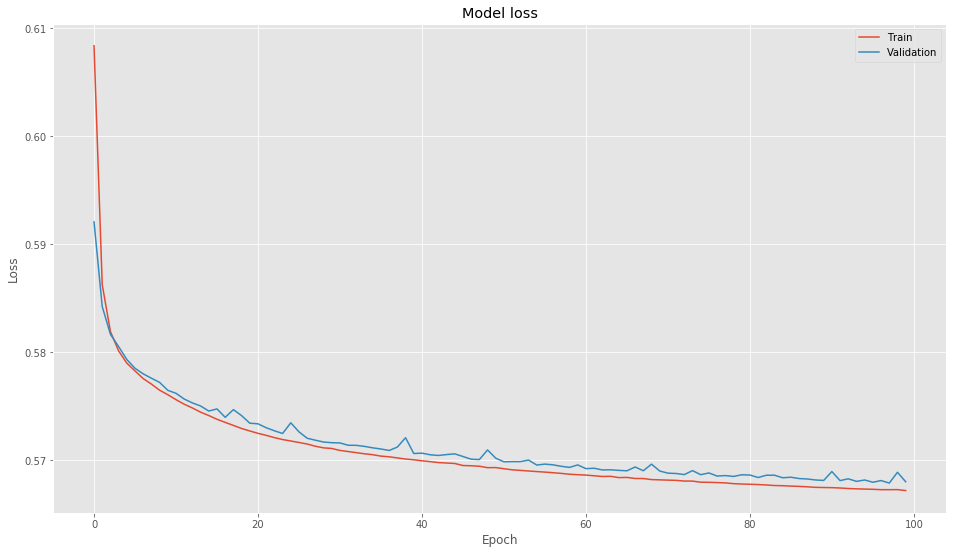

In [45]:
graph_plot_loss(aehistory)


In [46]:

autoencoder.save_weights('ae-cifar10-hc.h5')

In [47]:
autoencoder.load_weights("./ae-cifar10-hc.h5")

In [48]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test[image_idx].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(256, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

ValueError: Found array with dim 4. Estimator expected <= 2.

In [49]:
#Now perform dimension reduction

X_train_dr=encoder.predict(x_train)
X_test_dr=encoder.predict(x_test)

print(X_train_dr.shape,X_test_dr.shape)

(50000, 128) (10000, 128)


In [50]:
#Kmeans with Convolution Autoencoder

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

model=kmeans.fit(X_train_dr)

predicted_labels=model.predict(X_test_dr)




In [51]:

from sklearn.metrics import confusion_matrix

print ('Results of Kmeans with Convolution Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,predicted_labels))

Results of Kmeans with Convolution Autoencoder


Confusion Matrix: 

[[147  25 317  16 106  92  15 133  28 121]
 [ 67  79  29  83 166 241  70  96  55 114]
 [ 44  84  77  64  46  88  65  47 232 253]
 [ 55  94  17 157  69 113 109  28 123 235]
 [  8 113  26 165  57  68  71  19 277 196]
 [ 33 122  15 208  49 127  71  23 108 244]
 [ 59 185   5  84  30  73 131   8 254 171]
 [ 23  71  17 137 154  83  49  67 137 262]
 [ 20   9 231  40 214 160  20 230  16  60]
 [ 61  44  40  42 335 130  11 164  48 125]]


In [52]:
y_test= y_test.reshape(y_test.shape[0])

In [53]:
acc(y_test,predicted_labels)



Accuracy using linear assignment :  0.2208


Normalized Mutual Info Score :  0.10067873182391353


Adjusted Mutual Info Score :  0.09774054811882883


/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [54]:
#Gaussian Mixture Model with Deep Autoencoder

from sklearn.mixture import GaussianMixture 

gmm = GaussianMixture(n_components = 10) 
  
gmm_model=gmm.fit(X_train_dr) 
  
plabels = gmm_model.predict(X_test_dr) 


from sklearn.metrics import confusion_matrix

print ('Results of Gaussian Mixture Model with Deep Autoencoder\n\n')

print('Confusion Matrix: \n')

print(confusion_matrix(y_test,plabels))

acc(y_test,plabels)

Results of Gaussian Mixture Model with Deep Autoencoder


Confusion Matrix: 

[[ 67  75  30  88 204  63  46 118 227  82]
 [385 131  37   1  10  99  33  26  99 179]
 [ 33  93 127 265  37  33 238  67  48  59]
 [ 63 109 276  60   3  48 297  49  24  71]
 [ 33  67  62 238  27   9 198 178  79 109]
 [ 34  95 328  66   4  15 292  50  29  87]
 [ 73 101  69 198   9  53 390  36  36  35]
 [ 49  64 165  14   0  25 121 160  29 373]
 [131  59  22  34 152  20  58  77 371  76]
 [340 126  63   5   3  98  42  25  99 199]]


Accuracy using linear assignment :  0.2701


Normalized Mutual Info Score :  0.1456593570715526


Adjusted Mutual Info Score :  0.14197852761979524


/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/hasan/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


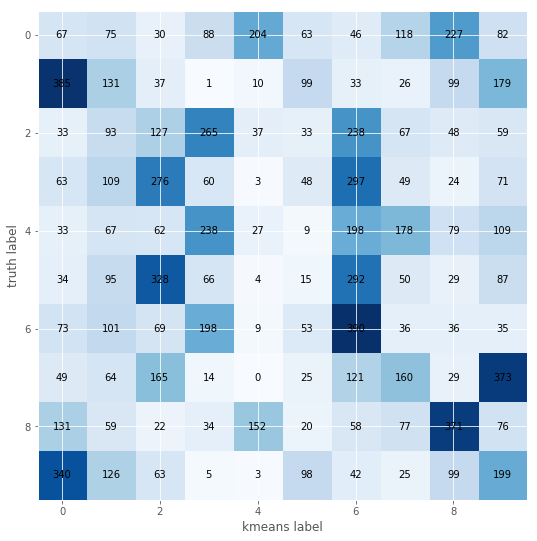

In [55]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, plabels)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

In [56]:
datacm=pd.DataFrame(cm)

In [57]:
datacm

,0,1,2,3,4,5,6,7,8,9
0,67,75,30,88,204,63,46,118,227,82
1,385,131,37,1,10,99,33,26,99,179
2,33,93,127,265,37,33,238,67,48,59
3,63,109,276,60,3,48,297,49,24,71
4,33,67,62,238,27,9,198,178,79,109
5,34,95,328,66,4,15,292,50,29,87
6,73,101,69,198,9,53,390,36,36,35
7,49,64,165,14,0,25,121,160,29,373
8,131,59,22,34,152,20,58,77,371,76
9,340,126,63,5,3,98,42,25,99,199


In [5]:
sm = [[ 67,  75,  30,  88, 204,  63,  46, 118, 227,  82],
 [385, 131,  37,   1,  10,  99,  33,  26,  99, 179],
 [ 33,  93, 127, 265,  37,  33, 238,  67,  48,  59,],
 [ 63, 109, 276,  60,   3,  48, 297,  49,  24,  71],
 [ 33,  67,  62, 238,  27,   9, 198, 178,  79, 109],
 [ 34,  95, 328,  66,   4,  15, 292,  50,  29,  87],
 [ 73, 101,  69, 198,   9,  53, 390,  36,  36,  35],
 [ 49,  64, 165,  14,   0,  25, 121, 160,  29, 373],
 [131,  59,  22,  34, 152,  20,  58,  77, 371,  76],
 [340, 126,  63,   5,   3,  98,  42,  25,  99, 199]]

In [6]:
labels1 = ["airplane",'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

[Text(0, 0.5, 'airplane'),
 Text(0, 1.5, 'automobile'),
 Text(0, 2.5, 'bird'),
 Text(0, 3.5, 'cat'),
 Text(0, 4.5, 'deer'),
 Text(0, 5.5, 'dog'),
 Text(0, 6.5, 'frog'),
 Text(0, 7.5, 'horse'),
 Text(0, 8.5, 'ship'),
 Text(0, 9.5, 'truck')]

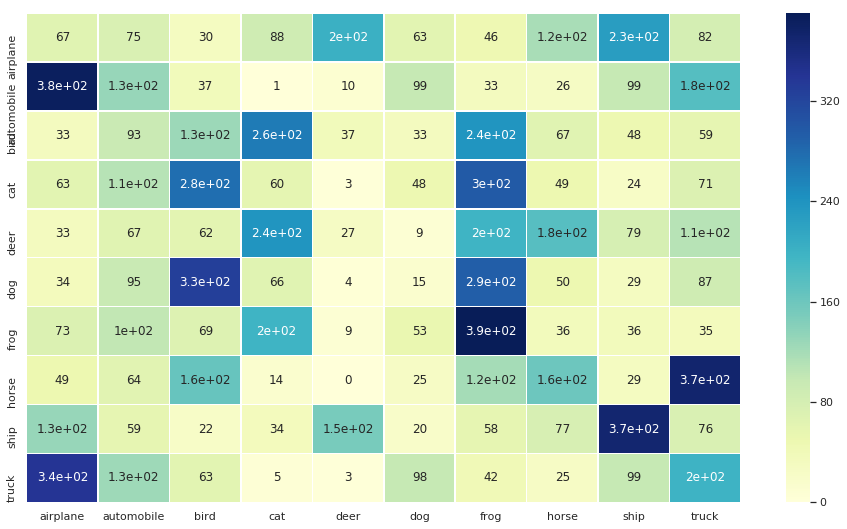

In [7]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
ax = sns.heatmap(sm,annot=True,linewidths=.5,cmap="YlGnBu")
ax.set_xticklabels(labels1)
ax.set_yticklabels(labels1)



In [39]:
X1 = X_train_dr[:5000,:]
Y= y_train[:5000]
X1.shape

(5000, 8192)

In [41]:
np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((256, 32)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X1, Y)

In [42]:
y.shape

(10000, 1)

In [43]:
# Visualize the clustering
def plot_clustering(X_red,X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(8, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

In [44]:
# 2D embedding of the dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X1)
print("Done.")

Computing embedding
Done.


In [45]:
X_red.shape

(5000, 2)

ward : 0.55s
average : 0.54s
complete : 0.50s


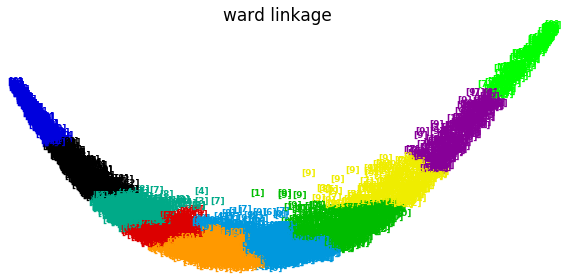

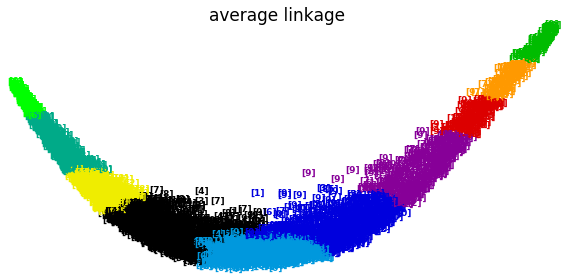

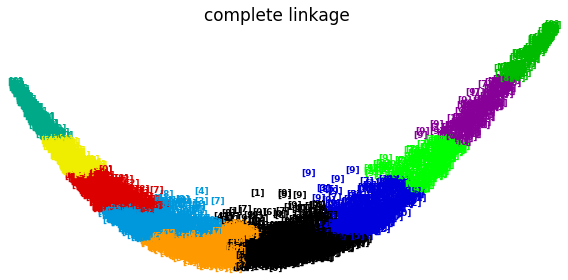

In [46]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red,X, clustering.labels_, "%s linkage" % linkage)
plt.show()

In [47]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [1]:

Z = hierarchy.linkage(X_red[:20,:], 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)

NameError: name 'hierarchy' is not defined